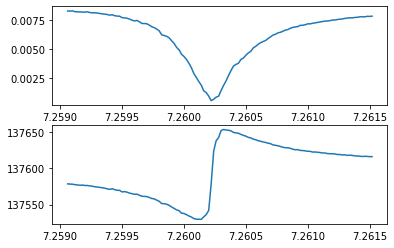

agebraic r0: 0.006865669130086166
iterative r0: 0.006116541658990648
agebraic r0: 0.006865669130086166
iterative r0: 0.006116541658990648
agebraic r0: 0.9434016952685759
iterative r0: 0.8404651688405569
===========Results===========
{'Qc_dia_corr': 36386.7575623284,
 'Qc_dia_corr_err': 31587.873982630874,
 'Qi_dia_corr': -90303.45095021023,
 'Qi_dia_corr_err': 140341.3528865327,
 'Qi_no_corr': -89499.73937963911,
 'Qi_no_corr_err': 130139.59781348774,
 'Ql': 60943.087758149355,
 'Ql_err': 56838.30563771038,
 'absQc': 36255.57013993923,
 'absQc_err': 31414.00719684192,
 'chi_square_': 9.540369243216768,
 'fr': 7.26046906789992,
 'fr_err': 6.829738892008526e-05,
 'phi0': -0.08494151201877324,
 'phi0_err': 0.6291439449770605,
 'residue': 1.485299218134713,
 'theta0': 2.321587129084576}
average number of photons in resonator at -130dBm input power 93.01870536655588
single photon limit power at input port(dBm) -149.6857029071115


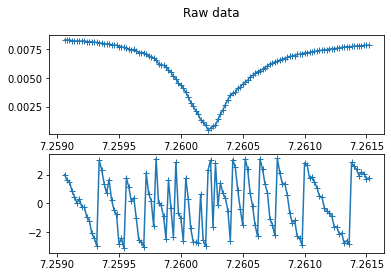

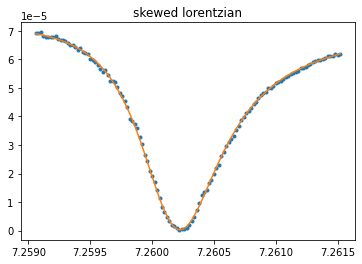

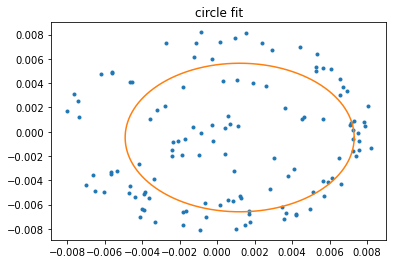

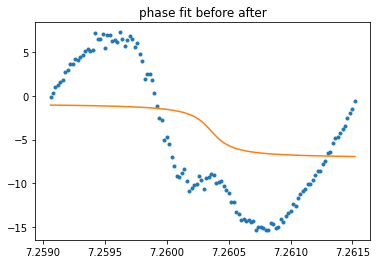

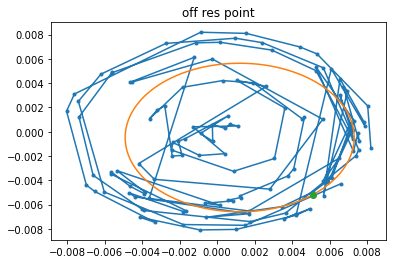

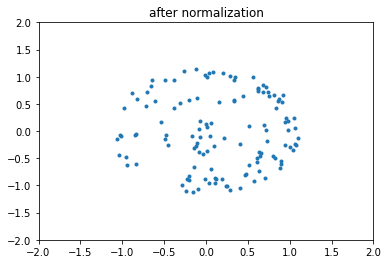

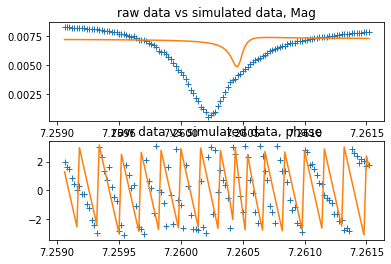

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 16 10:22:29 2016
This is a Python program to extract resonator quality factor using nonlinear fit. 
The following libraries are adapted from the codes from qkitgroup : https://github.com/qkitgroup/qkit
*calibration.py
*circlefit.py
*circuit.py
*utilities.py
@author: Wenyuan Zhang , wzhang@physics.rutgers.edu
"""
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spopt
from scipy import stats
from circuit import *
from utilities import phase_vs_freq
from pprint import pprint
from copy import deepcopy

def loaddata(fname,f_col=2,mag_col=4,phase_col=5,phase_unit='RAD'):
    data = np.loadtxt(fname,skiprows=3,)   
    f = data[:,0]#2
    mag=data[:,3]#3
    phase=-data[:,4]#4
#    phase = np.deg2rad(data[:,5])
    S21 = mag*np.cos(phase)+1j*mag*np.sin(phase)
    plt.close('all')
    fig,ax = plt.subplots(2,1)
    ax[0].plot(f,mag)
    ax[1].plot(f,phase)
    plt.show()
    return f, S21           

def fr_Ql_init(f,S21):
    S21 = S21 / np.abs(S21)[0]
    S21_abs= np.abs(S21)
    S21_FWHM = 1/2*(np.min(S21_abs)**2+1)
    print(S21_FWHM)
    fr_index = np.argmin(S21_abs)
    fr = f[fr_index]
    f_left = f[np.argmin(np.abs(S21_FWHM-S21_abs[0:fr_index]))]
    S21_left = S21_abs[np.argmin(np.abs(S21_FWHM-S21_abs[0:fr_index]))]
    f_right = f[fr_index+np.argmin(np.abs(S21_FWHM-S21_abs[fr_index:-1]))]
    S21_right = S21_abs[fr_index+np.argmin(np.abs(S21_FWHM-S21_abs[fr_index:-1]))]
    Ql = fr/(f_right-f_left)
    plt.subplots()
    plt.title('init fr, Ql')
    plt.plot(f,S21_abs)
    S21_sim = (np.min(S21_abs)+2j*Ql*(1-f/fr))/(1+2j*Ql*(1-f/fr))
    plt.plot(f,np.abs(S21_sim),f_left,S21_left,'o',f_right,S21_right,'o')
    return fr, Ql
    #%%
if __name__ == "__main__":

    plt.close("all")    
    angles=np.linspace(0,2*np.pi,2000)
    REMOVE_BACKGND = False # remove |S21| background slope or not. 

    # set file directory and name
#     fdir = 'D:\\Dropbox\\Drive\\Projects\\Resonator\\data\\AlOx\\'
#     data_file=['170627-ADC_InOx04_f7.11_ps500mK-181421.dat']
#     fname = fdir + data_file[0]
    fname = r'4_11_2013_LCmeander2_S21vsFreq_Pmeas=-133dBm_T=20mK'
    
    f,S21 = loaddata(fname, phase_unit='DEG') # phase_unit='DEG' or 'RAD'
    port = notch_port(f,S21)

    if False:
        index=np.arange(580,802)
#        index=np.hstack((index,np.arange(-100,-1)))
        f_data_origin=f[index]
        z_data_origin=S21[index]
    else:
        f_data_origin=f
        z_data_origin=S21
    
    f_data=f_data_origin
    z_data=z_data_origin

    plt.subplots(2,1)
    plt.suptitle('Raw data')
    plt.subplot(211)
    plt.plot(f_data,np.abs(z_data),'+-')
    plt.subplot(212)
    plt.plot(f_data,np.angle(z_data),'+-')

    if REMOVE_BACKGND:
#        frcal = f_data[np.argmin(np.abs(z_data))]
#        linear_var = port._fit_delay_and_linear_var_in_S21(f_data,z_data,frcal,delay,alpha=0,maxiter = 200)
        linear_var = -22
        z_data = z_data/(1+linear_var*(f_data/frcal-1)) 
    else: 
        linear_var = 0
    
    delay = port._guess_delay(f_data,z_data)
#    delay= 
    delay = port._fit_delay(f_data,z_data,delay,maxiter=200)
    A1, A2, A3, A4, frcal, Ql=port._fit_skewed_lorentzian(f_data,z_data)
    # remove delay
    z_data = z_data_origin*np.exp(2.*1j*np.pi*delay*f_data)
    
    if REMOVE_BACKGND:
        plt.subplots()
        plt.title('|S21| before and after background slope removed')
        plt.plot(f_data_origin,np.absolute(z_data_origin),'+')
        plt.plot(f_data,np.absolute(z_data),'.')

    xc, yc, r0 = port._fit_circle(z_data,refine_results=True)

    plt.subplots()
    plt.plot(np.real(z_data),np.imag(z_data),'.')
    plt.title('circle fit')
    xc, yc, r0 = port._fit_circle(z_data,refine_results=True)
    plt.plot(xc+r0*np.cos(angles),yc+r0*np.sin(angles))
## 
    zc = np.complex(xc,yc)
    theta = np.angle(port._center(z_data,zc))[np.argmin(f_data-frcal)]
    theta=-4
    fitparams = port._phase_fit(f_data,port._center(z_data,zc),theta,np.absolute(Ql),frcal)
    theta, Ql, fr = fitparams
    plt.subplots()
    plt.title('phase fit before after')
    _phase = np.angle(port._center(z_data,zc)) 
    plt.plot(f_data,np.unwrap(_phase),'.')

    if Ql<0:
        raise('Ql is less than zero')
    _phase = theta+2.*np.arctan(2.*Ql*(1.-f_data/fr))
    plt.plot(f_data, _phase)
#    beta = port._periodic_boundary(theta+np.pi,np.pi)
    beta = theta + np.pi
    offrespoint = np.complex((xc+r0*np.cos(beta)),(yc+r0*np.sin(beta)))
    alpha = np.angle(offrespoint)
    a = np.absolute(offrespoint)
    plt.subplots()
    plt.title('off res point')
    plt.plot(np.real(z_data),np.imag(z_data),'.-')
    plt.plot(xc+r0*np.cos(angles),yc+r0*np.sin(angles))
    plt.plot(offrespoint.real,offrespoint.imag,'o')
    # normalize 
    z_data = z_data/a*np.exp(1j*(-alpha))
    plt.subplots()
    plt.title('after normalization')
    plt.plot(z_data.real,z_data.imag,'.')
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    
    port.fitresults = port.circlefit(f_data,z_data,fr,Ql,refine_results=True,calc_errors=True,m=20)
    
    z_data_sim = port._S21_notch(f_data,fr=port.fitresults["fr"],Ql=port.fitresults["Ql"],Qc=port.fitresults["absQc"],phi=port.fitresults["phi0"],a=a,alpha=alpha,delay=delay) * (1+linear_var*(f_data/port.fitresults["fr"]-1))
    
    plt.subplots(2,1)
    plt.subplot(2,1,1)
    plt.title('raw data vs simulated data, Mag')
    plt.plot(f_data_origin,np.abs(z_data_origin),'+')
    plt.plot(f_data,np.abs(z_data_sim))
    plt.subplot(2,1,2)
    plt.title('raw data vs simulated data, phase')
    plt.plot(f_data_origin,np.angle(z_data_origin),'+')
    plt.plot(f_data,np.angle(z_data_sim))
    
    results = np.array([port.fitresults['fr'],
               port.fitresults['Qi_dia_corr'],
               port.fitresults['Qi_dia_corr_err'],
               port.fitresults['Qi_no_corr'],
               port.fitresults['Qi_no_corr_err'],
               port.fitresults['absQc'],
               port.fitresults['absQc_err'],
               port.fitresults['Qc_dia_corr'],
               port.fitresults['Ql'],
               port.fitresults['Ql_err'],
               port.fitresults['chi_square_'],
               delay,
               a,
               port.fitresults['Qc_dia_corr_err']
               ])
    results = np.reshape(results,(1,results.size))
    print('===========Results===========')
    pprint(port.fitresults)
    
    print('average number of photons in resonator at -130dBm input power', port.get_photons_in_resonator(-130))
    print('single photon limit power at input port(dBm)',port.get_single_photon_limit())
    
